# Objective
* Predict stock price in next day using linear regression
* Given prices for the last N days, we train a model, and predict for day N+1

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import sys
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "./VTI2.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['adj_close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        y_train = y_train.reshape(-1, 1)
        
         # Train the model
        regr.fit(X_train, y_train)           
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2001-06-15,55.424999,56.005001,55.174999,55.665001,39.889877,1067400,6
1,2001-06-18,55.814999,55.915001,55.310001,55.310001,39.635471,282600,6
2,2001-06-19,56.150002,56.165001,55.235001,55.465000,39.746536,1777600,6
3,2001-06-20,55.375000,56.075001,55.375000,56.049999,40.165779,476000,6
4,2001-06-21,56.000000,56.724998,55.875000,56.500000,40.488239,240400,6
5,2001-06-22,56.450001,56.450001,55.875000,56.139999,40.230259,180600,6
6,2001-06-25,56.099998,56.189999,55.389999,55.639999,39.971649,30400,6
7,2001-06-26,55.049999,55.775002,55.029999,55.494999,39.867470,146600,6
8,2001-06-27,55.599998,55.840000,55.235001,55.500000,39.871067,114000,6
9,2001-06-28,55.900002,56.689999,55.900002,56.180000,40.359585,357400,6


# Split into train, dev and test set

In [4]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 2686
num_cv = 895
num_test = 895
train.shape = (2686, 8)
cv.shape = (895, 8)
train_cv.shape = (3581, 8)
test.shape = (895, 8)


# Predict using Linear Regression

In [5]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv['est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

(2, 30)

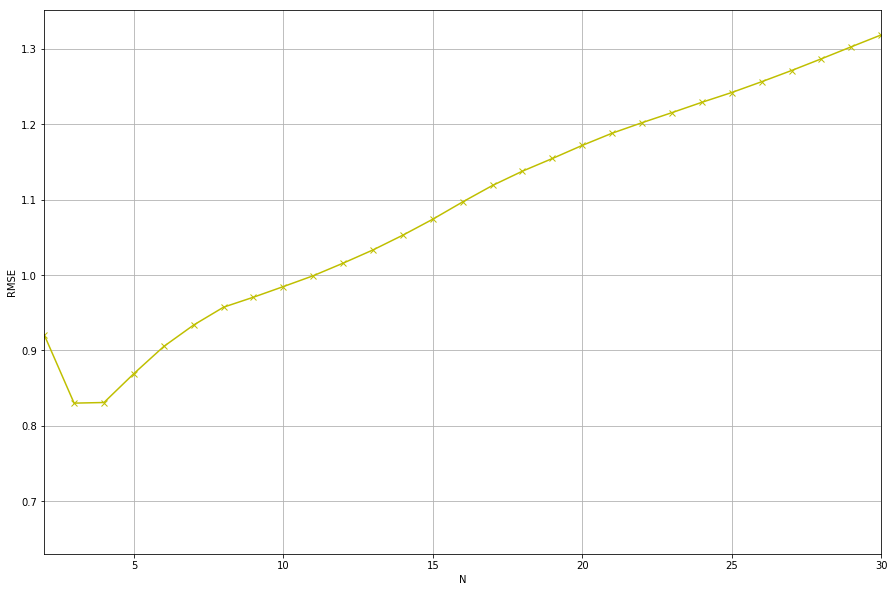

In [6]:
# Plot RMSE versus N
plt.figure(figsize=(15, 10))
plt.plot(range(1, Nmax+1), RMSE, 'yx-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])


### Lowest RMSE is achieved with N=3 and N=4

(2, 30)

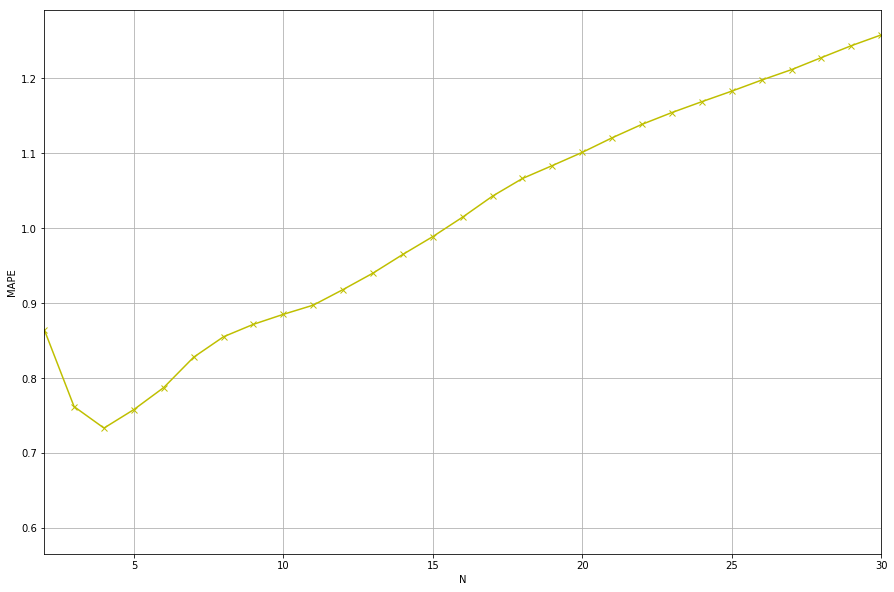

In [7]:
# Plot MAPE versus N. 
plt.figure(figsize=(15, 10))
plt.plot(range(1, Nmax+1), mape, 'yx-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 30])

In [8]:
# Set optimum N
N_opt = 4

# Plot predictions on Validation set

RMSE = 0.831
MAPE = 0.734%


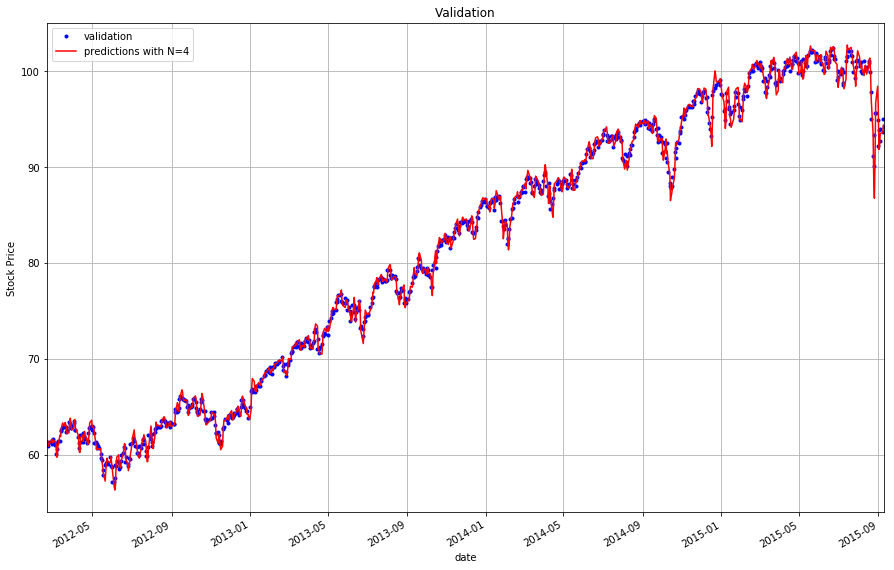

In [9]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8

ax = cv.plot(x='date', y='adj_close', style='b.', grid=True)
ax = cv.plot(x='date', y='est_N4', style='r-', grid=True, ax=ax)
ax.legend(['validation', 'predictions with N='+str(N_opt)])
ax.set_xlabel("date")
ax.set_ylabel("Stock Price")
ax.set_title("Validation")
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(cv['est_N4'], cv['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(cv['est_N4'], cv['adj_close']))


# Final model

In [10]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test['est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))

RMSE = 1.215
MAPE = 0.713%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'Testing')

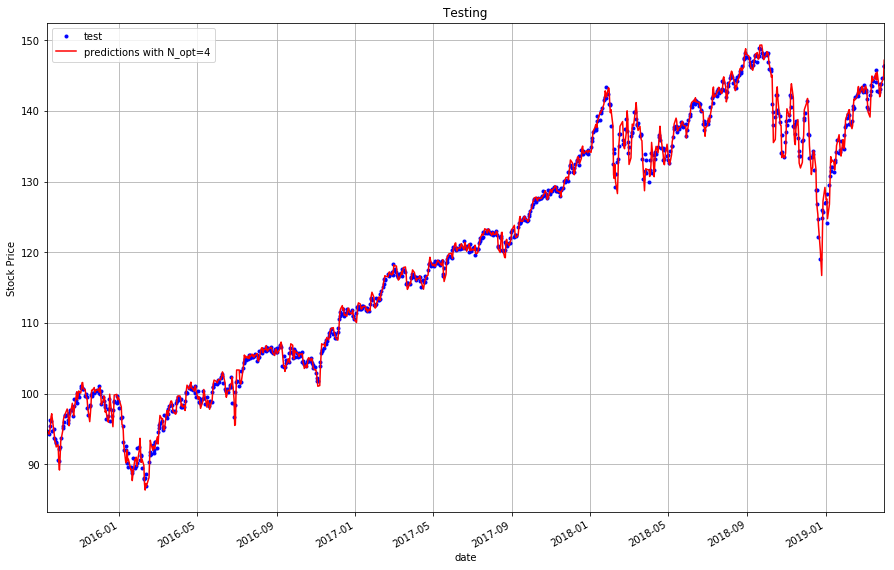

In [11]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8
ax = test.plot(x='date', y='adj_close', style='b.', grid=True)
ax = test.plot(x='date', y='est_N'+str(N_opt), style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions with N_opt=4'])
ax.set_xlabel("date")
ax.set_ylabel("Stock Price")
ax.set_title('Testing')